<a href="https://colab.research.google.com/github/gusdnhh/DeeplearningNote/blob/main/casava_leaf_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ecs-vlc/FMix.git

fatal: destination path 'FMix' already exists and is not an empty directory.


In [ ]:
!cp FMix/fmix.py .

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
%cd /content

/content


In [ ]:
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

<ipython-input-13-4376584a8884>:33: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [ ]:
!unzip /content/drive/MyDrive/cassava-leaf-disease-classification.zip -d /content/data/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data/train_images/3954487465.jpg  
  inflating: /content/data/train_images/3954910918.jpg  
  inflating: /content/data/train_images/3955391972.jpg  
  inflating: /content/data/train_images/3955442838.jpg  
  inflating: /content/data/train_images/3955739563.jpg  
  inflating: /content/data/train_images/3955931830.jpg  
  inflating: /content/data/train_images/3955972139.jpg  
  inflating: /content/data/train_images/3956075690.jpg  
  inflating: /content/data/train_images/3956077728.jpg  
  inflating: /content/data/train_images/3956155774.jpg  
  inflating: /content/data/train_images/3956271103.jpg  
  inflating: /content/data/train_images/3956372146.jpg  
  inflating: /content/data/train_images/3956407201.jpg  
  inflating: /content/data/train_images/3956550570.jpg  
  inflating: /content/data/train_images/3956605397.jpg  
  inflating: /content/data/train_images/3956778160.jpg  
  inflating: /content/data/train_images/3957562076.j

In [ ]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [ ]:
import pandas as pd

train = pd.read_csv('/content/data/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
train['label'].value_counts()

,count
label,
3,13158
4,2577
2,2386
1,2189
0,1087


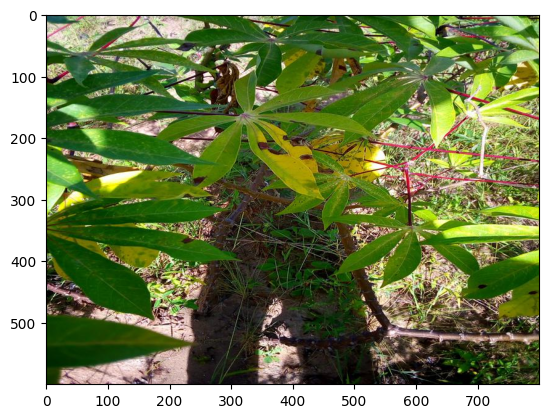

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('/content/data/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

In [ ]:
def rand_bbox(size, lam):
  W = size[0]
  H = size[1]
  cut_rat = np.sqrt(1. - lam)
  cut_w = np.int(W * cut_rat)
  cut_h = np.int(H * cut_rat)

  # uniform
  cx = np.random.randint(W)
  cy = np.random.randint(H)

  bbx1 = np.clip(cx - cut_w // 2, 0, W)
  bby1 = np.clip(cy - cut_h // 2, 0, H)
  bbx2 = np.clip(cx + cut_w // 2, 0, W)
  bby2 = np.clip(cy + cut_h // 2, 0, H)
  return bbx1, bby1, bbx2, bby2

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd

class CassavaDataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None):
    """
    csv_file (str or pd.DataFrame): 이미지 이름과 레이블이 포함된 CSV 파일 경로 또는 DataFrame 객체
    img_dir (str): 이미지 파일들이 저장된 디렉토리 경로
    transform (callable, optional): 이미지 전처리 함수
    """
    if isinstance(csv_file, str):
      self.data = pd.read_csv(csv_file)
    else:
      self.data = csv_file.reset_index(drop=True)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # 이미지 이름과 레이블 가져오기
    img_name =  self.data.loc[idx, 'image_id']
    label = self.data.loc[idx, 'label']

    # 이미지 경로 생성
    img_path = os.path.join(self.img_dir, img_name)

    # 이미지 로드 및 RGB 변환
    image = Image.open(img_path).convert('RGB')

    # 이미지 변환 적용
    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader

# CSV 파일 경로와 이미지 디렉토리 설정
csv_file = '/content/data/train.csv'
img_dir = '/content/data/train_images'

# 데이터 변환 파이프라인 정의
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # 추가적인 변환 가능
])

# 데이터셋 생성
dataset = CassavaDataset(csv_file=csv_file, img_dir=img_dir, transform=data_transforms)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# 데이터 확인
for images, labels in dataloader:
    print(images.size(), labels.size())
    # 모델 학습 코드 작성
    break


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
from sklearn.model_selection import StratifiedKFold

# StratifiedKFold 설정 (예: 5-fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df = pd.read_csv('/content/data/train.csv')

# 첫 번째 Fold 사용하여 분할
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df['label'])):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    valid_df = df.iloc[valid_idx].reset_index(drop=True)
    break  # 첫 번째 Fold만 사용

print(len(train_df))
print(len(valid_df))

17117
4280


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop((224,224,)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees = 15),
    transforms.ColorJitter(brightness=0.2, contrast = 0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 검증 데이터 변환
valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # 이미지 크기 조정
    transforms.CenterCrop((224, 224)),  # 중앙 크롭
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 이미지 정규화
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# 커스텀 데이터셋 생성
train_dataset = CassavaDataset(csv_file=train_df, img_dir='/content/data/train_images', transform=train_transforms)
valid_dataset = CassavaDataset(csv_file=valid_df, img_dir='/content/data/train_images', transform=valid_transforms)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

n_classes = 5

model = models.resnet50(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import time
import copy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr = 1e-5)

num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [ ]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 학습 결과를 저장할 리스트
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # 각 에포크마다 훈련 단계와 검증 단계를 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
                dataloader = train_loader
            else:
                model.eval()   # 모델을 평가 모드로 설정
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0

            # tqdm을 사용하여 진행률 표시
            data_iter = tqdm(dataloader, desc=f'{phase} Phase', leave=False)

            # 배치 단위로 데이터 로드
            for inputs, labels in data_iter:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 옵티마이저 초기화
                optimizer.zero_grad()

                # 순전파
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # 모델의 출력 형태에 따라 logits 또는 outputs 사용
                    if isinstance(outputs, torch.Tensor):
                        logits = outputs
                    else:
                        logits = outputs.logits

                    _, preds = torch.max(logits, 1)
                    loss = criterion(logits, labels)

                    # 학습 단계에서만 역전파 및 옵티마이저 업데이트 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # 손실 및 정확도 업데이트
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # tqdm 설명 업데이트
                data_iter.set_postfix(loss=loss.item())

            # 에포크 손실 및 정확도 계산
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 결과 저장
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

                # 가장 좋은 모델 저장
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # 가장 좋은 모델 가중치 로드
    model.load_state_dict(best_model_wts)

    # 학습 결과 반환
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }

    return model, history


In [ ]:
# 에포크 수 설정
num_epochs = 20

# 모델 학습
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20
--------------------


train Loss: 0.5573 Acc: 0.7982


val Loss: 0.5052 Acc: 0.8201

Epoch 2/20
--------------------


train Loss: 0.5572 Acc: 0.8002


val Loss: 0.4985 Acc: 0.8213

Epoch 3/20
--------------------


train Loss: 0.5572 Acc: 0.7963


val Loss: 0.4934 Acc: 0.8217

Epoch 4/20
--------------------


train Loss: 0.5581 Acc: 0.7980


val Loss: 0.5014 Acc: 0.8187

Epoch 5/20
--------------------


train Loss: 0.5652 Acc: 0.7956


val Loss: 0.4959 Acc: 0.8206

Epoch 6/20
--------------------


train Loss: 0.5577 Acc: 0.7989


val Loss: 0.4979 Acc: 0.8213

Epoch 7/20
--------------------


train Loss: 0.5624 Acc: 0.7961


val Loss: 0.4930 Acc: 0.8224

Epoch 8/20
--------------------


train Loss: 0.5556 Acc: 0.7988


val Loss: 0.4971 Acc: 0.8208

Epoch 9/20
--------------------


train Loss: 0.5583 Acc: 0.7997


val Loss: 0.5056 Acc: 0.8182

Epoch 10/20
--------------------


train Loss: 0.5607 Acc: 0.8010


val Loss: 0.4969 Acc: 0.8224

Epoch 11/20
--------------------


train Loss: 0.5617 Acc: 0.7980


val Loss: 0.4943 Acc: 0.8208

Epoch 12/20
--------------------


train Loss: 0.5615 Acc: 0.7975


val Loss: 0.4944 Acc: 0.8215

Epoch 13/20
--------------------


train Loss: 0.5591 Acc: 0.7968


val Loss: 0.4928 Acc: 0.8220

Epoch 14/20
--------------------


train Loss: 0.5570 Acc: 0.8002


val Loss: 0.4964 Acc: 0.8208

Epoch 15/20
--------------------


train Loss: 0.5593 Acc: 0.7994


val Loss: 0.5030 Acc: 0.8178

Epoch 16/20
--------------------


train Loss: 0.5656 Acc: 0.7946


val Loss: 0.4982 Acc: 0.8196

Epoch 17/20
--------------------


train Loss: 0.5606 Acc: 0.7961


val Loss: 0.5003 Acc: 0.8192

Epoch 18/20
--------------------


train Loss: 0.5612 Acc: 0.7991


val Loss: 0.4962 Acc: 0.8206

Epoch 19/20
--------------------


train Loss: 0.5627 Acc: 0.7984


val Loss: 0.4959 Acc: 0.8203

Epoch 20/20
--------------------


train Loss: 0.5586 Acc: 0.7974


val Loss: 0.4987 Acc: 0.8224

Training complete in 113m 16s
Best val Acc: 0.8224


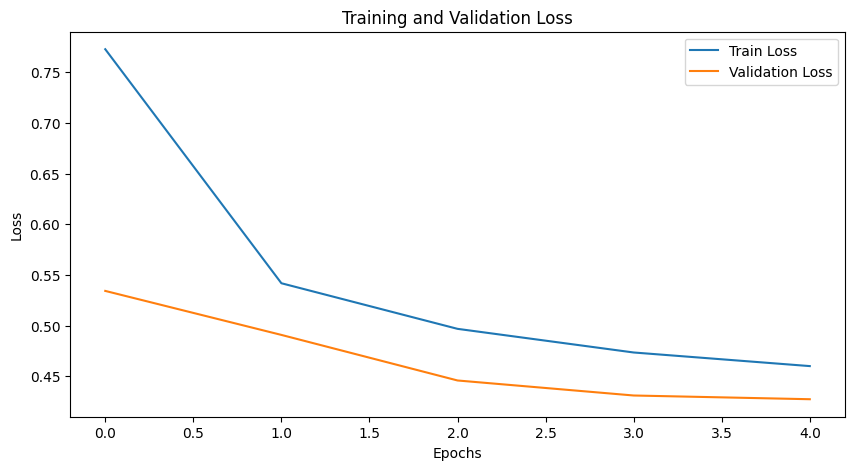

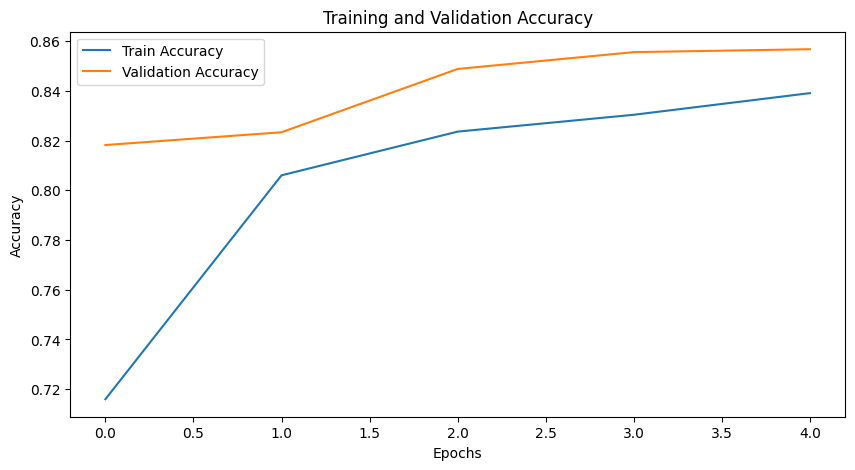

In [ ]:
# 손실 시각화
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(history['train_loss'], label="Train Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 정확도 시각화
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot([acc.cpu() for acc in history['train_acc']], label="Train Accuracy")
plt.plot([acc.cpu() for acc in history['val_acc']], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
